In [1]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from data.prep import get_data_as_dataframe
from utils.data_utils import custom_train_test_split, calculate_mean_std

from plots import plot_acc_loss_curve

from models.vit import ViT

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils.train_utils import EarlyStopping
from engine import train, eval

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [3]:
# ROOT path
ROOT = os.getcwd()

# Training mode
PRETRAINED = False

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Preparation

In [4]:
# Path to datasets
DATA_PATH = os.path.join(ROOT, 'dataset')

# Dataset name
DATASET_NAME = 'SUT-Crack'

df = get_data_as_dataframe(DATA_PATH, dataset_name=DATASET_NAME, balance=True)
df.head()

,image,label
0,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
1,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
2,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
3,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
4,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked


In [5]:
# define the train & test split
TEST_SIZE = 0.2

train_df, valid_df, test_df = custom_train_test_split(df, test_size=TEST_SIZE, stratify='label')

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (3017, 2)
Validation size: (566, 2)
Test size: (189, 2)


In [6]:
print(f"Train data balance:\n {train_df.label.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.label.value_counts()}\n")
print(f"Test data balance:\n {test_df.label.value_counts()}\n")

Train data balance:
 non-cracked    1509
cracked        1508
Name: label, dtype: int64

Validation data balance:
 cracked        283
non-cracked    283
Name: label, dtype: int64

Test data balance:
 cracked        95
non-cracked    94
Name: label, dtype: int64



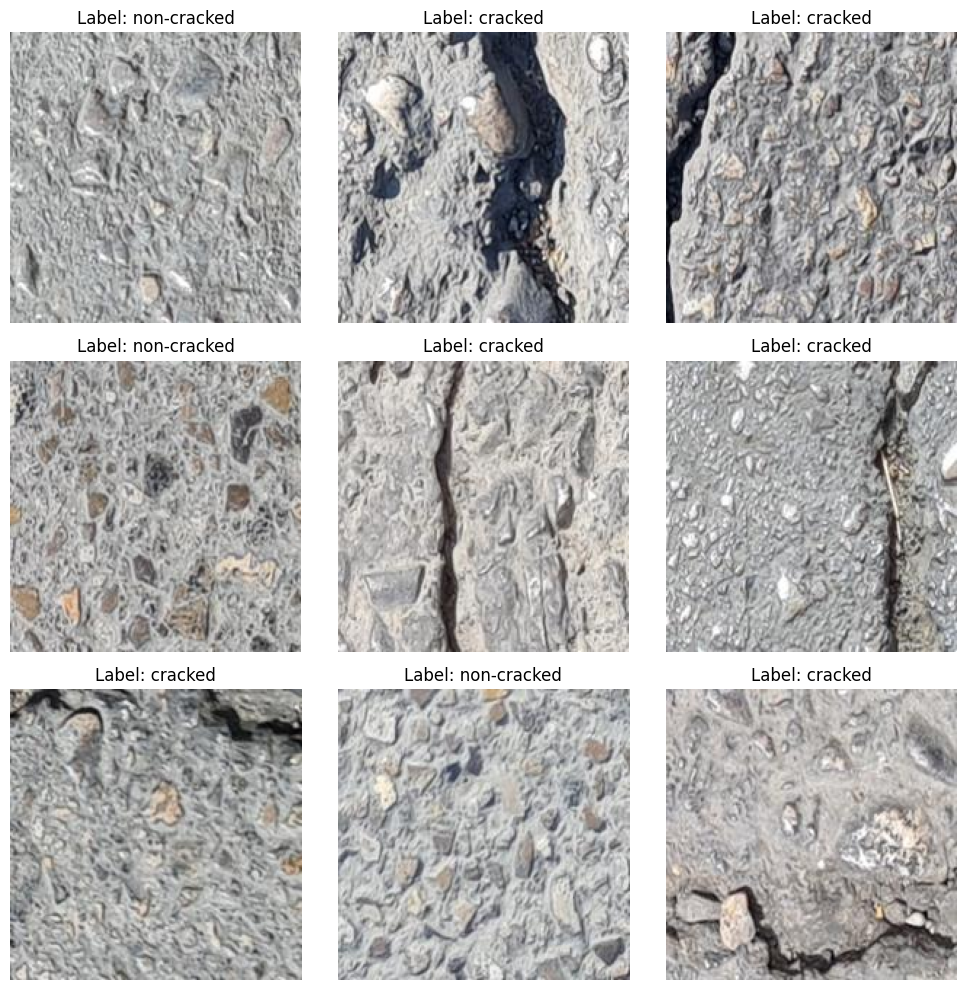

In [7]:
from plots import show_df

show_df(df=df, n_samples=9)

# Initialize Dataset and Dataloader for Training

In [8]:
class CrackDataset(Dataset):
    def __init__(self, df, dataset_name, transform=None):
        super().__init__()
        self.df_data = df.values
        self.dataset_name = dataset_name
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if label=='cracked' else 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 64

if PRETRAINED:
    MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
else:
    MEAN, STD = calculate_mean_std(train_df.copy())

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD), 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
}

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY),
    'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY),
    'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY)
}

Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: 64


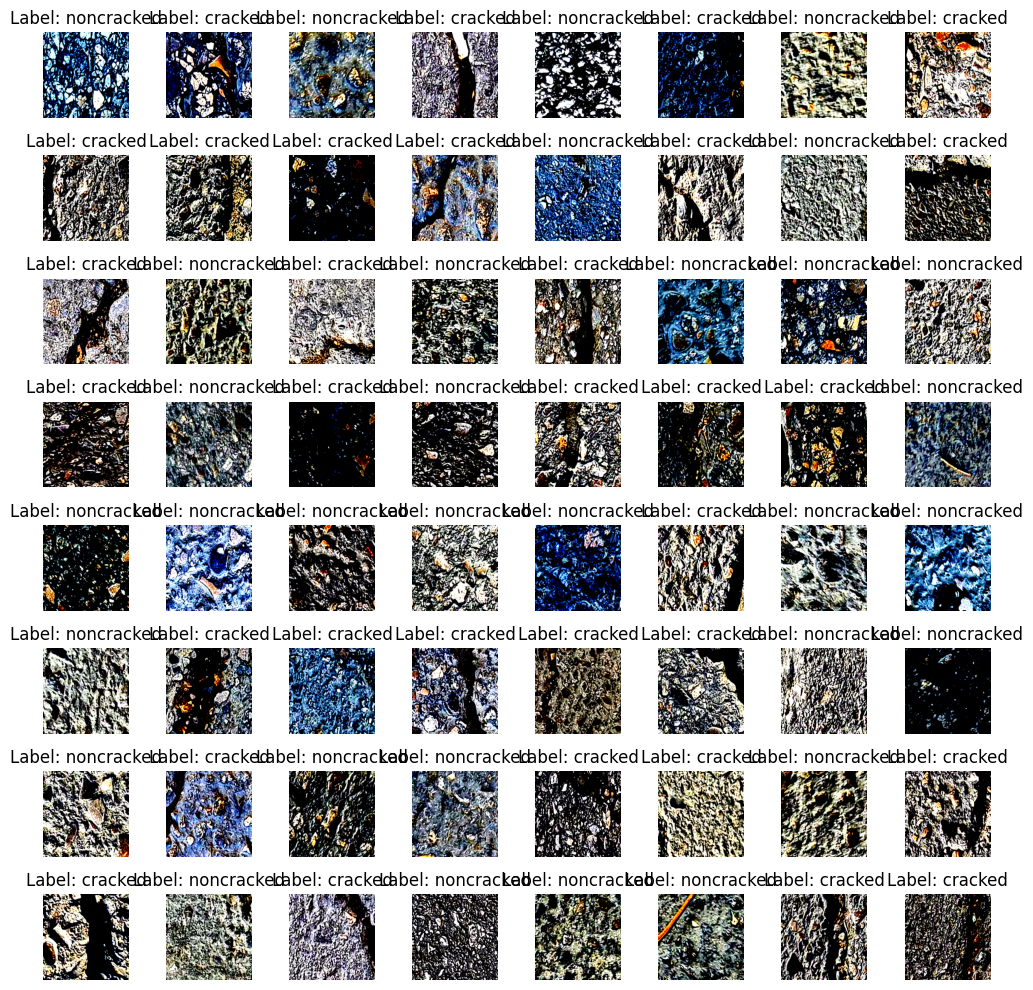

In [10]:
from plots import show_dl

show_dl(dataloaders['train'])

# ViT (Vision Transformer) Architecture

In [17]:
num_classes = len(df.label.unique())
model = ViT(size='base', patch_size=16, num_classes=num_classes, pretrained=PRETRAINED)

In [18]:
for layer, param in model.named_parameters():
    if param.requires_grad:
        print(layer)

# Fine-tune ViT

In [19]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 5e-3
MOMENTUM = 0.9

# Send the model to GPU
model = model.to(DEVICE)

# Setup the loss function
criterion = torch.nn.CrossEntropyLoss()

# Model parameters where requires grad is True
params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM, weight_decay=1e-5)

optimizer = optim.Adam(params_to_tune, lr=INIT_LR, weight_decay=1e-5)

# Update learning rate once validation loss stop decreasing
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1.5e-4)

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

In [ ]:
import os
import time
import yaml
from datetime import datetime
from collections import OrderedDict

import torch
from sklearn.metrics import accuracy_score, classification_report

from utils.train_utils import epoch_time

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    # Set the model to train mode
    model.train()

    y_pred = []
    y_true = []

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the optimizer gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = (torch.max(torch.exp(outputs), 1))
        y_pred.extend(preds.data.cpu().numpy()) # Save Predictions
        y_true.extend(labels.data.cpu().numpy()) # Save Actual

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(y_true, y_pred)

    return train_loss, train_acc

def eval(model, val_loader, criterion, device, eval_test=False):
    # Set the model to evaluation mode
    model.eval()

    y_pred = []
    y_true = []
    
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = (torch.max(torch.exp(outputs), 1))
            y_pred.extend(preds.data.cpu().numpy()) # Save Predictions
            y_true.extend(labels.data.cpu().numpy()) # Save Actual

            # Calculate loss
            loss = criterion(outputs, labels)

            # Update the running loss
            running_loss += loss.item() * inputs.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = accuracy_score(y_true, y_pred)

    if eval_test: 
        print(classification_report(y_true, y_pred))
        return y_pred, y_true
    else:
        return val_loss, val_acc

def train(model, NUM_EPOCHS, dataloaders, device, criterion, optimizer, scheduler=None, early_stopping=None, checkpoint_interval=None, multiple_gpu=False, verbose=True):

    # Init training params
    params = {
        'num_epochs': NUM_EPOCHS,
        'dataset': dataloaders['train'].dataset.dataset_name,
        'dataset_size': len(dataloaders['train'].dataset) + len(dataloaders['valid'].dataset) + len(dataloaders['test'].dataset),
        'batch_size': dataloaders['train'].batch_size,
        'model_name': model.model_name,
        'pretrained': model.pretrained,
        'criterion': type(criterion).__name__,
        'optimizer': type(optimizer).__name__,        
    }

    if params['optimizer'] == 'SGD':
        params['opt_learning_rate'] = optimizer.param_groups[0]['lr'] 
        params['opt_momentum'] = optimizer.param_groups[0]['momentum']
        params['opt_weight_decay'] = optimizer.param_groups[0]['weight_decay']
    
    if params['optimizer'] == 'Adam':
        params['opt_learning_rate'] = optimizer.param_groups[0]['lr'] 
        params['opt_weight_decay'] = optimizer.param_groups[0]['weight_decay']
    
    if scheduler:
        params['scheduler'] = type(scheduler).__name__
        params['scheduler_factor'] = scheduler.factor
        params['scheduler_patience'] = scheduler.patience
        params['scheduler_threshold'] = scheduler.threshold

    # Init experiments folder
    now = datetime.now().strftime("%Y-%m-%d %H-%M")
    save_dir = f"experiments/({now}) {params['model_name']}_on_{params['dataset']}_w_epoch_{params['num_epochs']}_lr_{params['opt_learning_rate']}"
    os.makedirs(save_dir, exist_ok=True)

    # Save training params
    params_path = os.path.join(save_dir, 'params.yaml')
    with open(params_path, 'w') as f:
        yaml.dump(params, f, sort_keys=False)

    if multiple_gpu:
        model = torch.nn.DataParallel(model, device_ids=[0, 1])

    train_hist = {
        'train_losses': [],
        'train_accs': [],
        'val_losses': [],
        'val_accs': []
    }

    best_val_loss = float('inf')

    for epoch in range(NUM_EPOCHS):

        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
        val_loss, val_acc = eval(model, dataloaders['valid'], criterion, device)
            
        train_hist['train_losses'].append(train_loss)
        train_hist['train_accs'].append(train_acc)
        
        train_hist['val_losses'].append(val_loss)
        train_hist['val_accs'].append(val_acc)

        # Adjust learning rate
        if scheduler:
            if params['scheduler']=='ReduceLROnPlateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save checkpoint
        if checkpoint_interval:
            checkpoints_dir = os.path.join(save_dir, 'checkpoints') 
            os.makedirs(checkpoints_dir, exist_ok=True)
            if (epoch + 1) % checkpoint_interval == 0:
                checkpoint_state = OrderedDict([
                    ('model_state_dict', model.state_dict()),
                    ('optimizer_state_dict', optimizer.state_dict()),
                    ('epoch', epoch + 1),
                ])
                torch.save(checkpoint_state, os.path.join(checkpoints_dir, f'checkpoint_{epoch+1}.pt'))
        
        # Save best model
        weights_dir = os.path.join(save_dir, 'weights') 
        os.makedirs(weights_dir, exist_ok=True)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(weights_dir, 'best.pt'))
        
        # Save last model
        torch.save(model.state_dict(), os.path.join(weights_dir, 'last.pt'))

        if early_stopping:
            
        
        end_time = time.time()

        if verbose:
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            # print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | Epoch Time: {epoch_mins}m {epoch_secs}s')
            lr = optimizer.param_groups[0]['lr']
            memory_usage = int(torch.cuda.max_memory_allocated(device)/1024/1024)
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | Learning Rate: {lr} | mem: {memory_usage}')
            print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\tVal. Loss: {val_loss:.4f} | Val. Acc: {val_acc*100:.2f}%')

    return train_hist

In [28]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

NUM_EPOCHS = 50

train_hist = train(model, NUM_EPOCHS, dataloaders, DEVICE, criterion, optimizer, scheduler, multiple_gpu=True)

Epoch [1/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.6972 | Train Acc: 53.23%
	Val. Loss: 0.6996 | Val. Acc: 50.00%
Epoch [2/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.6981 | Train Acc: 56.18%
	Val. Loss: 0.6489 | Val. Acc: 51.94%
Epoch [3/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.6261 | Train Acc: 63.90%
	Val. Loss: 0.7909 | Val. Acc: 52.30%
Epoch [4/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.3963 | Train Acc: 83.39%
	Val. Loss: 0.2960 | Val. Acc: 87.99%
Epoch [5/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.3072 | Train Acc: 87.37%
	Val. Loss: 0.2623 | Val. Acc: 88.52%
Epoch [6/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.2964 | Train Acc: 87.67%
	Val. Loss: 0.3014 | Val. Acc: 86.57%
Epoch [7/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.2926 | Train Acc: 88.00%
	Val. Loss: 0.4194 | Val. Acc: 84.98%
Epoch [8/50] | Learning Rate: 0.005 | mem: 5977
	Train Loss: 0.2827 | Train Acc: 88.63%
	Val. Loss: 0.2529 | Val. Acc:

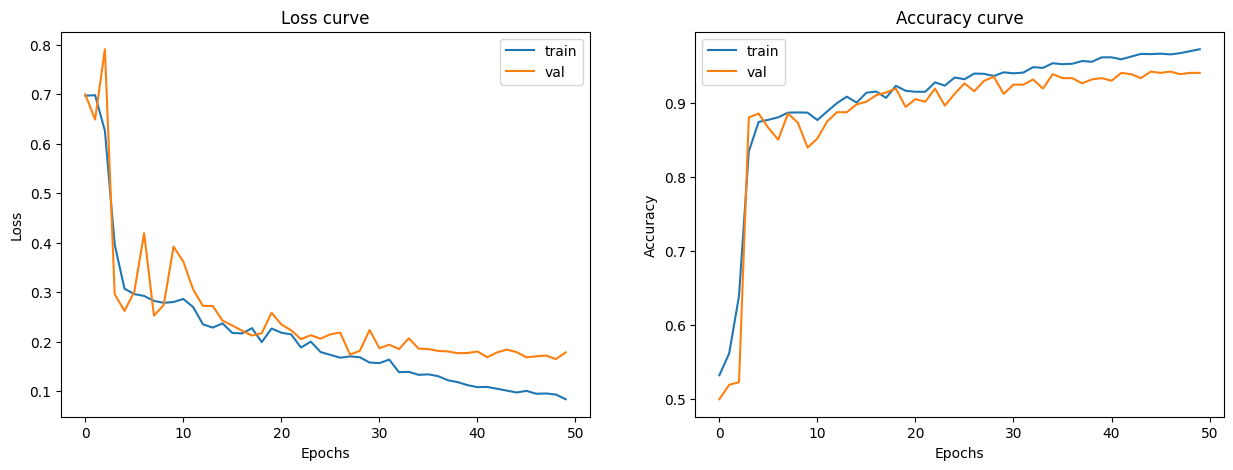

In [29]:
plot_acc_loss_curve(train_hist)

In [24]:
for i in ['train', 'valid', 'test']: 
    model.eval()

    batch_loss = 0.0
    batch_corrects = 0
    # Iterate over the batches of the validation loader
    with torch.no_grad():
        for inputs, labels in dataloaders[i]:
            # Move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update the running loss and accuracy
            batch_loss += loss.item() * inputs.size(0)
            batch_corrects += torch.sum(preds == labels.data)

    test_dataset_len = dataloaders[i].dataset.__len__()
    test_loss = batch_loss / test_dataset_len
    test_acc = batch_corrects.double() / test_dataset_len

    print(f"{i} loss: {test_loss}, {i} acc: {test_acc}")

train loss: 0.11498150340534125, train acc: 0.9621284755512943
valid loss: 0.8901628206363887, valid acc: 0.7407407407407408
test loss: 0.9911246280688153, test acc: 0.7011494252873562


In [23]:
# def train_one_epoch(model, dataloaders, criterion, optimizer):
#     for phase in ['train', 'valid']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(phase=='train'):
#                 # Get model outputs and calculate loss
#                 # Special case for inception because in training it has an auxiliary output. In train
#                 #   mode we calculate the loss by summing the final output and the auxiliary output
#                 #   but in testing we only consider the final output.
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 _, preds = torch.max(outputs, 1)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(dataloaders[phase].dataset)
#         epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
#         return epoch_loss, epoch_acc

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
#     since = time.time()

#     val_acc_history = []
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [25]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/99
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
